# Time Series Dataset untuk Prediksi

## Pengambilan Data NO₂ Sentinel-5P untuk Wilayah Sumenep melalui openEO

Kode berikut digunakan untuk memperoleh data konsentrasi Nitrogen Dioksida (NO₂) dari satelit **Sentinel-5P** menggunakan layanan **openEO**. Data ini dimanfaatkan untuk menganalisis kualitas udara di wilayah Sumenep berdasarkan periode waktu tertentu.

Tahapan proses:

1. **Autentikasi ke openEO**
   Langkah pertama adalah melakukan autentikasi ke endpoint `openeo.dataspace.copernicus.eu` menggunakan metode **OIDC (OpenID Connect)** agar dapat mengakses dataset Sentinel-5P.

2. **Penentuan Area of Interest (AOI)**
   AOI (area yang diteliti) didefinisikan sebagai poligon berisi koordinat lintang dan bujur yang mencakup wilayah Sumenep. Area ini menjadi fokus utama pengambilan data.

3. **Pemanggilan Koleksi Data Sentinel-5P**
   Koleksi `SENTINEL_5P_L2` dimuat dengan rentang waktu tertentu (misalnya dari tanggal mulai hingga tanggal akhir) dan area pembatas (bounding box) yang sedikit lebih besar dari AOI. Hal ini dilakukan untuk mengantisipasi resolusi spasial Sentinel-5P yang berkisar ±7 km.

4. **Agregasi Temporal (Rata-rata Harian)**
   Karena data Sentinel-5P dapat tersedia beberapa kali dalam satu hari, dilakukan proses agregasi temporal dengan menghitung rata-rata per hari untuk memperoleh nilai harian NO₂.

5. **Agregasi Spasial Berdasarkan AOI**
   Nilai NO₂ selanjutnya dirata-ratakan berdasarkan area AOI yang telah ditentukan, yaitu wilayah Sumenep.

6. **Eksekusi Batch dan Penyimpanan Hasil**
   Proses pengolahan dijalankan sebagai **batch job** di server openEO, dan hasil akhirnya disimpan dalam format **NetCDF (.nc)** agar dapat digunakan untuk analisis lanjutan, seperti pemodelan deret waktu (time series) atau prediksi kualitas udara.


In [1]:
!pip install openeo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.1/335.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.10.1
    Uninstalling xarray-2025.10.1:
      Successfully uninstalled xarray-2025.10.1


In [11]:
import openeo

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

aoi = {
    "type": "Polygon",
        "coordinates": [
        [
            [
                113.45,
                -7.25
            ],
            [
                113.45,
                -6.75
            ],
            [
                114.05,
                -6.75
            ],
            [
                114.05,
                -7.25
            ],
            [
                113.45,
                -7.25
            ]
        ]
    ],
    "type": "Polygon"
}

s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2023-10-15", "2025-10-19"],
    spatial_extent={
        "west": 113.45,
        "south": -7.25,
        "east": 114.05,
        "north": -6.75
    },
    bands=["NO2"]
)

s5p_no2_daily = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

s5p_no2_aoi = s5p_no2_daily.aggregate_spatial(
    geometries=aoi,
    reducer="mean"
)

job = s5p_no2.execute_batch(title="NO2 in Sumenep", outputfile="NO2_in_Sumenep.nc")

Authenticated using refresh token.
0:00:00 Job 'j-25102213153646cd97feb3470677ebf0': send 'start'
0:00:13 Job 'j-25102213153646cd97feb3470677ebf0': created (progress 0%)
0:00:18 Job 'j-25102213153646cd97feb3470677ebf0': created (progress 0%)
0:00:25 Job 'j-25102213153646cd97feb3470677ebf0': created (progress 0%)
0:00:33 Job 'j-25102213153646cd97feb3470677ebf0': running (progress N/A)
0:00:43 Job 'j-25102213153646cd97feb3470677ebf0': running (progress N/A)
0:00:55 Job 'j-25102213153646cd97feb3470677ebf0': running (progress N/A)
0:01:11 Job 'j-25102213153646cd97feb3470677ebf0': running (progress N/A)
0:01:30 Job 'j-25102213153646cd97feb3470677ebf0': running (progress N/A)
0:01:54 Job 'j-25102213153646cd97feb3470677ebf0': running (progress N/A)
0:02:24 Job 'j-25102213153646cd97feb3470677ebf0': running (progress N/A)
0:03:02 Job 'j-25102213153646cd97feb3470677ebf0': running (progress N/A)
0:03:49 Job 'j-25102213153646cd97feb3470677ebf0': running (progress N/A)
0:04:47 Job 'j-25102213153646

## Membaca Hasil Ekspor NetCDF dan Mengekstrak Variabel NO₂

Setelah proses pengambilan data dari **openEO** selesai dan hasilnya disimpan dalam file `NO2_in_sumenep.nc`, langkah berikutnya adalah membaca isi file tersebut serta mengekstrak variabel-variabel yang tersedia di dalamnya.

Format **NetCDF (.nc)** merupakan format standar untuk penyimpanan data satelit dan iklim, karena mendukung struktur data multidimensi — seperti data spasial (lintang, bujur) dan temporal (waktu). Untuk membaca file ini, digunakan pustaka **`netCDF4`**.

Langkah-langkah yang dilakukan:

1. **Membuka file `.nc` menggunakan `netCDF4.Dataset`**
   File hasil ekspor dibuka sehingga seluruh informasi metadata dan variabel dapat diakses.

2. **Melihat daftar variabel dalam dataset**
   Langkah ini berguna untuk mengidentifikasi variabel yang relevan, seperti konsentrasi NO₂, serta variabel waktu yang biasanya bernama `"time"` atau `"t"`.

3. **Mengambil data NO₂ dan waktu**
   Nilai konsentrasi NO₂ dibaca dalam bentuk array multidimensi, sementara data waktu biasanya tersimpan dalam bentuk nilai offset (contohnya “days since 1970-01-01”).

4. **Mengonversi waktu menjadi format tanggal**
   Dengan memanfaatkan atribut `units` pada variabel waktu, nilai offset tersebut dapat diubah menjadi format `datetime` agar lebih mudah dianalisis.

5. **Menampilkan cuplikan data**
   Untuk memastikan proses pembacaan berhasil, beberapa nilai awal dari variabel NO₂ dan waktu ditampilkan sebagai contoh.




In [13]:
!pip install netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.1 MB/s eta 0:00:00


In [14]:
import netCDF4

file_path = "/content/NO2_in_Sumenep.nc"
ds = netCDF4.Dataset(file_path)

print(" Variabel dalam file:")
print(ds.variables.keys())

no2 = ds.variables["NO2"][:]

time = ds.variables["t"][:]

try:
    time_units = ds.variables["t"].units
    dates = netCDF4.num2date(time, units=time_units)
except Exception:
    dates = time
print("\n📅 Contoh data pertama:")
for i in range(min(10, len(no2))):
    print(f"{dates[i]} | NO2: {no2[i]}")

 Variabel dalam file:
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])

📅 Contoh data pertama:
2023-10-15 00:00:00 | NO2: [[8.966615496319719e-06 -2.392675241935649e-06 -3.0093137866060715e-06
  1.001477812678786e-05 1.7949954781215638e-05 6.251369086385239e-06
  1.1501825611048844e-05 3.560855475370772e-06 3.647016228569555e-06
  1.4542471035383642e-05 1.032557338476181e-05]
 [3.7396214338514255e-06 4.4958237594983075e-06 -3.0093137866060715e-06
  1.001477812678786e-05 1.1489659300423227e-05 -5.246918135526357e-06
  8.04716364655178e-06 4.42362619423875e-07 1.1687496225931682e-05
  1.4542471035383642e-05 1.032557338476181e-05]
 [8.006143616512418e-06 1.295386755373329e-05 -6.859128461655928e-06
  1.3635681170853786e-05 1.1489659300423227e-05 -5.246918135526357e-06
  6.050181582395453e-06 6.969158675929066e-06 1.0722932529461104e-05
  9.662238880991936e-06 1.5079879631230142e-05]
 [8.006143616512418e-06 1.295386755373329e-05 1.782755134627223e-05
  5.527882422029506e-06 7.848360837670043e-06 5

## Konversi Data NetCDF ke CSV untuk Analisis Lebih Lanjut

Kode di bawah digunakan untuk membaca hasil keluaran data Sentinel-5P dalam format NetCDF (.nc) yang telah diunduh dari layanan openEO untuk wilayah Sumenep. Pertama, file NO2_in_Sumenep.nc dibuka menggunakan pustaka netCDF4, kemudian seluruh variabel di dalamnya ditampilkan untuk memastikan ketersediaan data yang diperlukan — yaitu variabel waktu ("t") dan konsentrasi NO₂ ("NO2"). Selanjutnya, nilai waktu dikonversi dari format offset (misalnya “days since 1970-01-01”) menjadi format tanggal sebenarnya menggunakan fungsi num2date().

Setelah itu, data NO₂ diekstraksi dan dirata-ratakan secara spasial menggunakan fungsi np.nanmean() agar menghasilkan satu nilai rata-rata per waktu pengamatan. Hasilnya kemudian digabungkan dengan nilai waktu ke dalam sebuah DataFrame pandas, yang memudahkan untuk analisis atau visualisasi lanjutan. Terakhir, DataFrame tersebut disimpan ke dalam file CSV dengan nama NO2_Sumenep.csv, dan beberapa baris pertama ditampilkan untuk memastikan bahwa proses konversi dan ekspor berjalan dengan benar.


In [16]:
import netCDF4
import pandas as pd
import numpy as np

file_path = "/content/NO2_in_Sumenep.nc"
ds = netCDF4.Dataset(file_path)

print(ds)

print(ds.variables.keys())

time_var = ds.variables["t"][:]
no2_var = ds.variables["NO2"][:]

time_units = ds.variables["t"].units
dates = netCDF4.num2date(time_var, units=time_units)

if no2_var.ndim > 1:
    no2_mean = np.nanmean(no2_var, axis=tuple(range(1, no2_var.ndim)))
else:
    no2_mean = no2_var

df = pd.DataFrame({
    "time": dates,
    "NO2": no2_mean
})

df.to_csv("/content/NO2_Sumenep.csv", index=False)
print(" File NO2_Sumenep.csv berhasil dibuat.")
print(df.head())

<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.9
    institution: Copernicus Data Space Ecosystem openEO API - 0.68.0a10.dev20250930+2976
    description: 
    title: 
    dimensions(sizes): t(728), y(15), x(11)
    variables(dimensions): int32 t(t), float64 x(x), float64 y(y), |S1 crs(), float32 NO2(t, y, x)
    groups: 
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])
 File NO2_Sumenep.csv berhasil dibuat.
                  time       NO2
0  2023-10-15 00:00:00  0.000007
1  2023-10-16 00:00:00  0.000013
2  2023-10-17 00:00:00  0.000018
3  2023-10-18 00:00:00  0.000014
4  2023-10-19 00:00:00  0.000014


## Transformasi Data NO₂ Menjadi Bentuk Supervised Learning

Kode di bawah digunakan untuk mempersiapkan dataset deret waktu (time series) NO₂ agar dapat digunakan dalam model prediksi atau pembelajaran mesin. Pertama, file hasil ekspor NO2_Sumenep.csv dibaca menggunakan pandas, kemudian kolom time dikonversi menjadi format tanggal dan dijadikan sebagai indeks waktu. Langkah interpolasi dengan method='time' dilakukan untuk mengisi nilai hilang (NaN) berdasarkan urutan waktu, sehingga data menjadi lebih kontinu dan siap digunakan untuk analisis deret waktu tanpa kehilangan pola temporalnya.

Selanjutnya, kode membuat dataset dalam bentuk supervised learning dengan membangkitkan fitur lag — yaitu nilai NO₂ dari beberapa hari sebelumnya (NO2(t-1), NO2(t-2), dst.) hingga n_lags = 4. Nilai-nilai lag ini digunakan sebagai variabel input untuk memprediksi nilai NO₂ pada waktu sekarang (NO2(t)). Setelah kolom-kolom lag terbentuk, baris yang mengandung nilai NaN akibat pergeseran waktu dihapus agar data bersih dan siap untuk pelatihan model prediksi. Hasil akhirnya adalah tabel dengan struktur berurutan yang menunjukkan hubungan antara kondisi masa lalu dan kondisi terkini konsentrasi NO₂ di wilayah Sumenep.

In [18]:
import pandas as pd

df = pd.read_csv("/content/NO2_Sumenep.csv")

df['time'] = pd.to_datetime(df['time'], errors='coerce')

df = df.set_index('time')

df['NO2'] = df['NO2'].interpolate(method='time')

print(df.isna().sum())

n_lags = 4

supervised = pd.DataFrame()

for i in range(n_lags, 0, -1):
    supervised[f'NO2(t-{i})'] = df['NO2'].shift(i)

supervised['NO2(t)'] = df['NO2']

supervised = supervised.dropna()

print("📅 Head of Data:")
print(supervised.head())

print("")
print("📦 Data info:")
supervised.info

NO2    0
dtype: int64
📅 Head of Data:
            NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2023-10-19  0.000007  0.000013  0.000018  0.000014  0.000014
2023-10-20  0.000013  0.000018  0.000014  0.000014  0.000013
2023-10-21  0.000018  0.000014  0.000014  0.000013  0.000017
2023-10-22  0.000014  0.000014  0.000013  0.000017  0.000015
2023-10-23  0.000014  0.000013  0.000017  0.000015  0.000015

📦 Data info:


<bound method DataFrame.info of             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2023-10-19  0.000007  0.000013  0.000018  0.000014  0.000014
2023-10-20  0.000013  0.000018  0.000014  0.000014  0.000013
2023-10-21  0.000018  0.000014  0.000014  0.000013  0.000017
2023-10-22  0.000014  0.000014  0.000013  0.000017  0.000015
2023-10-23  0.000014  0.000013  0.000017  0.000015  0.000015
...              ...       ...       ...       ...       ...
2025-10-14  0.000017  0.000009  0.000011  0.000015  0.000017
2025-10-15  0.000009  0.000011  0.000015  0.000017  0.000012
2025-10-16  0.000011  0.000015  0.000017  0.000012  0.000019
2025-10-17  0.000015  0.000017  0.000012  0.000019  0.000013
2025-10-18  0.000017  0.000012  0.000019  0.000013  0.000015

[724 rows x 5 columns]>

## Normalisasi Data untuk Model Supervised Learning

Kode ini digunakan untuk **menormalkan data deret waktu** sebelum digunakan dalam proses pelatihan model prediksi. Pertama, data dibagi menjadi dua bagian: variabel fitur (`X`) yang berisi empat nilai lag NO₂ sebelumnya (`NO2(t-4)` hingga `NO2(t-1)`) dan variabel target (`y`) yang berisi nilai NO₂ saat ini (`NO2(t)`). Proses ini penting agar model dapat belajar hubungan antara nilai masa lalu dan nilai sekarang. Kemudian, digunakan **`MinMaxScaler`** dari pustaka `scikit-learn` untuk menyesuaikan skala data ke rentang **0 hingga 1**, sehingga setiap fitur memiliki skala yang sebanding dan tidak mendominasi model akibat perbedaan satuan atau besaran nilai.

Setelah dilakukan normalisasi, hasil transformasi disimpan dalam variabel `X_scaled` dan diubah kembali menjadi **DataFrame `normalized_df`** dengan nama kolom yang sama seperti sebelumnya agar mudah dibaca dan diolah lebih lanjut. Normalisasi ini sangat penting dalam algoritma pembelajaran mesin seperti **LSTM, RNN, atau regresi linier**, karena membantu model konvergen lebih cepat dan meningkatkan stabilitas perhitungan numerik. Bagian terakhir dari kode menampilkan perbandingan antara data sebelum dan sesudah normalisasi untuk memastikan bahwa proses penskalaan telah berhasil dilakukan dengan benar.


In [19]:
from sklearn.preprocessing import MinMaxScaler

X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

supervised = supervised.reset_index()

normalized_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Sebelum normalisasi:\n", X.head())
print("\nSesudah normalisasi:\n", normalized_df.head())

Sebelum normalisasi:
             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
time                                              
2023-10-19  0.000007  0.000013  0.000018  0.000014
2023-10-20  0.000013  0.000018  0.000014  0.000014
2023-10-21  0.000018  0.000014  0.000014  0.000013
2023-10-22  0.000014  0.000014  0.000013  0.000017
2023-10-23  0.000014  0.000013  0.000017  0.000015

Sesudah normalisasi:
    NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
0  0.410881  0.509829  0.592648  0.515581
1  0.509829  0.592648  0.515581  0.512861
2  0.592648  0.515581  0.512861  0.503735
3  0.515581  0.512861  0.503735  0.571636
4  0.512861  0.503735  0.571636  0.529179


## Pemodelan Time Series NO₂ Menggunakan K-Nearest Neighbors (KNN) Regressor

Kode ini digunakan untuk **membangun dan mengevaluasi model prediksi kadar NO₂ menggunakan algoritma K-Nearest Neighbors (KNN) Regressor**. Pertama, dataset dibagi menjadi dua bagian, yaitu **data latih (80%) dan data uji (20%)** menggunakan fungsi `train_test_split` tanpa pengacakan waktu (`shuffle=False`) karena urutan waktu harus dipertahankan dalam analisis deret waktu. Empat nilai lag sebelumnya (`NO2(t-4)` hingga `NO2(t-1)`) digunakan sebagai input fitur (`X`), sedangkan nilai NO₂ saat ini (`NO2(t)`) menjadi target (`y`). Dua versi model KNN diuji berdasarkan parameter **`weights`**, yaitu `"uniform"` (semua tetangga memiliki bobot sama) dan `"distance"` (tetangga yang lebih dekat memiliki bobot lebih besar).

Selanjutnya, kode menghitung **Root Mean Squared Error (RMSE)** dan **koefisien determinasi (R²)** untuk mengukur kinerja model pada data uji. RMSE menunjukkan seberapa besar kesalahan rata-rata prediksi terhadap nilai aktual, sedangkan R² menunjukkan seberapa baik model menjelaskan variasi data (semakin mendekati 1 berarti semakin baik). Hasil prediksi dan data aktual kemudian divisualisasikan menggunakan **matplotlib**, di mana grafik atas menampilkan model dengan bobot `"uniform"` dan grafik bawah dengan bobot `"distance"`. Visualisasi ini memudahkan analisis apakah model KNN mampu mengikuti pola variasi NO₂ berdasarkan data historis di wilayah Sumenep.


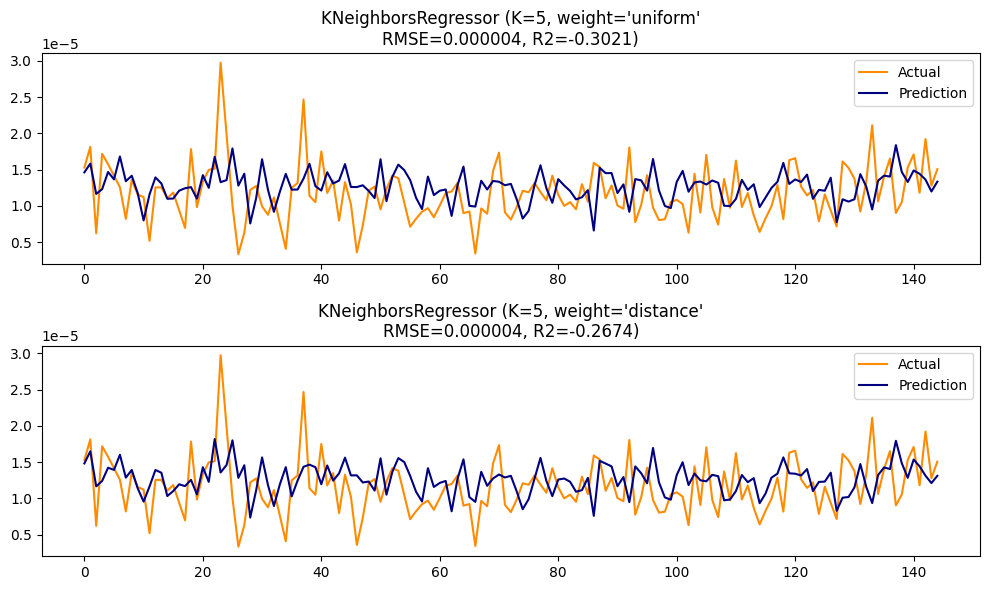

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

n_neighbors = 5

plt.figure(figsize=(10, 6))

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    plt.subplot(2, 1, i + 1)
    plt.plot(range(len(y_test)), y_test, 'darkorange', label="Actual")
    plt.plot(range(len(y_pred)), y_pred, 'navy', label="Prediction")
    plt.title(f"KNeighborsRegressor (K={n_neighbors}, weight='{weights}'\nRMSE={rmse:.6f}, R2={r2:.4f})")
    plt.legend()
    plt.tight_layout()

plt.show()